In [1]:
# Autor: Luiz Felipe Barros Alves

- Project filter CDWM
- Source: "Cascaded Mach-Zehnder wavelength filters in silicon photonics for low loss and flat pass-band WDM (de-)multiplexing,"

In [2]:
import sys, os, imp
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c
from scipy.signal import find_peaks

C:\Users\alves\AppData\Local\Temp\ipykernel_21876\1292900171.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import sys, os, imp


In [3]:
lumapiFile = "/opt/lumerical/v221/api/python/lumapi.py"
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
lumapi = imp.load_source("lumapi", lumapiFile)
interApi = lumapi.INTERCONNECT(hide = False)
interApi.expressioncheckoff()


In [4]:
# units
um = 1e-6
nm = 1e-9

# index
# neff = 2.3531702
# ng = 4.3458796

# index PDK
neff = 2.44553
ng = 4.19088

wvlngth_start = 1530 * nm
wvlngth_stop = 1565 * nm
center_wvlg = 1550 * nm

number_of_points = 50e3

In [5]:
# Function to determine the correct coupling lengths for each D.C.
def coupling(length):
    L_array = np.array([])
    dif_array_50 = np.array([])
    dif_array_29 = np.array([])
    dif_array_8 = np.array([])

    target_29 = 10*np.log10(0.29)
    target_8 = 10*np.log10(0.08) 

    for L in length:
        interApi.switchtolayout()
        interApi.select('coupler')
        interApi.set('coupling_length', L)

        interApi.run()
        input_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
        input_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')

        gain_1 = input_1["'TE' gain (dB)"]
        gain_2 = input_2["'TE' gain (dB)"]

        L_array = np.append(L_array, L)
        dif_array_50 = np.append(dif_array_50, np.mean(np.abs(gain_1-gain_2)))
        dif_array_29 = np.append(dif_array_29, np.mean(np.abs(gain_1-target_29)))
        dif_array_8 = np.append(dif_array_8, np.mean(np.abs(gain_1-target_8)))

    idx_50 = dif_array_50.argmin()
    idx_29 = dif_array_29.argmin()
    idx_8 = dif_array_8.argmin()

    print(f"Coupling length to 50% : {L_array[idx_50]/um}um\n"   
            f"Coupling length to 29%: {L_array[idx_29]/um}um\n" 
            f"Coupling length to 8%: {L_array[idx_8]/um}um")

In [6]:
# Function to draw the photonic circuit

def filter_2st(L_50, L_29, L_8, L, delta_L, delta_L_shift, name_prefix, position_x, position_y): 
    interApi.switchtolayout()


    names = {
        'coupler_1': f'{name_prefix}_coupler_1',
        'coupler_2': f'{name_prefix}_coupler_2',
        'coupler_3': f'{name_prefix}_coupler_3',
        'wg_1': f'{name_prefix}_wg_1',
        'wg_2': f'{name_prefix}_wg_2',
        'wg_3': f'{name_prefix}_wg_3',
        'wg_4': f'{name_prefix}_wg_4'
    }

     # Removes existing elements with the same names
    for element in names.values():
        interApi.select(element)
        interApi.delete()

    # Add elements 
    interApi.addelement('ebeam_dc_te1550')
    interApi.set('name', names['coupler_1'])
    interApi.set('coupling_length', L_50)

    interApi.addelement('ebeam_dc_te1550')
    interApi.set('name', names['coupler_2'])
    interApi.set('coupling_length', L_29)

    interApi.addelement('ebeam_dc_te1550')
    interApi.set('name', names['coupler_3'])
    interApi.set('coupling_length', L_8)

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name',  names['wg_1'])
    interApi.set('wg_length', L + delta_L + delta_L_shift)
    
    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name',  names['wg_2'])
    interApi.set('wg_length', L )

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name',  names['wg_3'])
    interApi.set('wg_length', L)

    interApi.addelement('ebeam_wg_integral_1550')
    interApi.set('name',  names['wg_4'])
    interApi.set('wg_length', L + 2*delta_L + 2*delta_L_shift)

    # positions
    interApi.setposition(names['coupler_1'], -200 + position_x, 50 + position_y)
    interApi.setposition(names['coupler_2'], 100 + position_x, 50 + position_y)
    interApi.setposition(names['coupler_3'], 400 + position_x, 50 + position_y)
    interApi.setposition(names['wg_1'], -50 + position_x,-100 + position_y)
    interApi.setposition(names['wg_2'], -50 + position_x, 150 + position_y)
    interApi.setposition(names['wg_3'], 250 + position_x,-100 + position_y)
    interApi.setposition(names['wg_4'], 250 + position_x, 150 + position_y)

    # connection
    # interApi.connect("ONA", "output", names['coupler_1'] , "opt_2")
    interApi.connect(names['coupler_1'], "opt_3", names['wg_1'], "port 1")
    interApi.connect(names['coupler_1'], "opt_4", names['wg_2'], "port 1")
    interApi.connect(names['wg_1'], "port 2", names['coupler_2'], "opt_1")
    interApi.connect(names['wg_2'], "port 2", names['coupler_2'], "opt_2")
    interApi.connect(names['coupler_2'], "opt_3", names['wg_3'], "port 1")
    interApi.connect(names['coupler_2'], "opt_4", names['wg_4'], "port 1")
    interApi.connect(names['wg_3'], "port 2", names['coupler_3'], "opt_1")
    interApi.connect(names['wg_4'], "port 2", names['coupler_3'], "opt_2")
    # interApi.connect(names['coupler_3'], "opt_3", "ONA", "input 1")
    # interApi.connect(names['coupler_3'], "opt_4", "ONA", "input 2")

    return names  # returns the names of the elements for external control

In [7]:
# Function plot gain

def plot_gain(gain_1, gain_2, gain_3, gain_4, gain_5, gain_6, gain_7, gain_8, name, freq):
    min_indices, _ = find_peaks(-np.array(gain_1["'TE' gain (dB)"]))

    if len(min_indices) >= 2:
        min_1, min_2 = min_indices[10:12]  
        x_min_1, x_min_2 = gain_1['wavelength'][min_1] / nm, gain_1['wavelength'][min_2] / nm
        y_min = gain_1["'TE' gain (dB)"][min_2]

        plt.figure(figsize=(12, 6))
        plt.plot(gain_1['wavelength']/nm , gain_1["'TE' gain (dB)"], lw=1, label='output 1')
        plt.plot(gain_2['wavelength']/nm , gain_2["'TE' gain (dB)"], lw=1, label='output 2')
        plt.plot(gain_3['wavelength']/nm , gain_3["'TE' gain (dB)"], lw=1, label='output 3')
        plt.plot(gain_4['wavelength']/nm , gain_4["'TE' gain (dB)"], lw=1, label='output 4')
        plt.plot(gain_5['wavelength']/nm , gain_5["'TE' gain (dB)"], lw=1, label='output 5')
        plt.plot(gain_6['wavelength']/nm , gain_6["'TE' gain (dB)"], lw=1, label='output 6')
        plt.plot(gain_7['wavelength']/nm , gain_7["'TE' gain (dB)"], lw=1, label='output 7')
        plt.plot(gain_8['wavelength']/nm , gain_8["'TE' gain (dB)"], lw=1, label='output 8')

        plt.plot([wvlngth_start/nm, wvlngth_stop/nm], [-3, -3], label='-3dB', ls='--', color='black')
        # plt.hlines(y=-3, xmin=wvlngth_start, xmax=wvlngth_stop, colors='black', ls='--')
        # plt.hlines(y=y_min, xmin=x_min_1, xmax=x_min_2, color='black', linestyle='--')
        # plt.text(center_wvlg/nm, 1, f'{float(x_min_1 - x_min_2):.1f} nm')

        plt.xlabel('$\lambda$ (nm)')
        plt.ylabel('Gain (dB)')
        plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
        plt.ylim([-40, 2])

        plt.title(f'CDWM {name}-order Filters (PDK SiEPIC {freq}GHz)')
        plt.minorticks_on()
        plt.grid(which='both', linestyle='--', linewidth=0.5)  
        plt.grid(which='minor', linestyle=':', linewidth=0.5) 

        plt.legend(loc='lower right')
        plt.savefig(f'{freq}PDK{name}_order_filters', bbox_inches='tight')
        plt.show()

In [8]:
# Function plot gain

def plot_gain_zoom(gain_1, gain_2, gain_3, gain_4, gain_5, gain_6, gain_7, gain_8, name, freq):
    min_indices, _ = find_peaks(np.array(gain_1["'TE' gain (dB)"]))

    if len(min_indices) >= 2:
        
        # min_1 = min_indices[81]  
        # min_2 = min_indices[82]
        # x_min_1, x_min_2 = gain_1['wavelength'][min_1] / nm, gain_1['wavelength'][min_2] / nm
        # y_min = gain_1["'TE gain (dB)"][min_2]
        
        plt.figure(figsize=(12, 6))
        plt.plot(gain_1['wavelength']/nm , gain_1["'TE' gain (dB)"], lw=1, label='output 1')
        plt.plot(gain_2['wavelength']/nm , gain_2["'TE' gain (dB)"], lw=1, label='output 2')
        plt.plot(gain_3['wavelength']/nm , gain_3["'TE' gain (dB)"], lw=1, label='output 3')
        plt.plot(gain_4['wavelength']/nm , gain_4["'TE' gain (dB)"], lw=1, label='output 4')
        plt.plot(gain_5['wavelength']/nm , gain_5["'TE' gain (dB)"], lw=1, label='output 5')
        plt.plot(gain_6['wavelength']/nm , gain_6["'TE' gain (dB)"], lw=1, label='output 6')
        plt.plot(gain_7['wavelength']/nm , gain_7["'TE' gain (dB)"], lw=1, label='output 7')
        plt.plot(gain_8['wavelength']/nm , gain_8["'TE' gain (dB)"], lw=1, label='output 8')

        xticks = [1544.53, 1545.32, 1546.12, 1546.92, 1547.72, 1548.51, 1549.32, 1550.12, 1550.92]
        channels = [41, 40, 39, 38, 37, 36, 35, 34, 33]

        for i, j in zip(xticks, channels):
            plt.plot([i, i], [-4, 1], ls=':', color='black')
            plt.text(i+0.05, -2.5, f'Channel {j}', rotation=90)

        plt.xlabel('$\lambda$ (nm)')
        plt.ylabel('Gain (dB)')
        plt.xlim([center_wvlg/nm - 2, center_wvlg/nm + 2])
        plt.ylim([-3, 2])

        plt.hlines(y=-3, xmin=wvlngth_start/nm, xmax=wvlngth_stop/nm, colors='black', ls='--')
        # plt.hlines(y=0, xmin=x_min_1, xmax=x_min_2, color='black', linestyle='--')
        # plt.text(center_wvlg/nm, 0.2, f'{float(x_min_1 - x_min_2):.1f} nm')

        plt.title(f'CDWM {name}-order Filters (PDK SiEPIC {freq}GHz)')
        plt.minorticks_on()
        plt.grid(which='both', linestyle='--', linewidth=0.5)  
        plt.grid(which='minor', linestyle=':', linewidth=0.5) 

        plt.xticks(xticks)
        plt.xlim([xticks[0]-0.4, xticks[-1]+0.4])
        plt.ylim([-4, 0.5])

        plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
        plt.savefig(f'zoom_{freq}_PDK_{name}_order_filters', bbox_inches='tight')
        plt.show()

In [9]:
interApi.switchtolayout()
interApi.select('ONA')
interApi.delete()

# ONA

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.set('number of input ports', 8)
interApi.set('input parameter', 2)
interApi.set('start frequency', c/wvlngth_start)
interApi.set('stop frequency', c/wvlngth_stop)
interApi.set('number of points', number_of_points)

interApi.setposition('ONA', -500, -1800)


# Simulation of the couplers to determine the proper mating length

In [10]:
interApi.switchtolayout()
interApi.select('coupler')
interApi.delete()


interApi.addelement('ebeam_dc_te1550')
interApi.set('name', 'coupler')

interApi.connect('ONA', 'output', 'coupler', 'opt_2')
interApi.connect('ONA', 'input 1', 'coupler', 'opt_3')
interApi.connect('ONA', 'input 2', 'coupler', 'opt_4')

1.0

In [11]:
length = np.arange(0, 50, 2.5) * um
coupling(length)

Coupling length to 50% : 17.5um
Coupling length to 29%: 12.5um
Coupling length to 8%: 5.0um


# Simulação espaçamento entre canais 50GHz
Pré-requisitos:

- **Número de entradas**: 1  
- **Número de saídas**: 8  
- **Espaçamento entre canais**: 50, 100 e 200 GHz  
- **Banda de operação**: banda C (1530 – 1565 nm)  
- **O filtro deve estar alinhado com os canais definidos pelo padrão ITU da banda C**  
  [https://www.fiberdyne.com/products/pdf/Fiberdyne-ITU-Grid-C-Band-100GHz.pdf](https://www.fiberdyne.com/products/pdf/Fiberdyne-ITU-Grid-C-Band-100GHz.pdf)  
- **Uso de filtros de, no mínimo, segunda ordem**  
- **Uso de acopladores de grade**  
- **Tamanho máximo do circuito**: 500 × 400 µm  
- **Uso da PDK SiePIC**  
  [https://github.com/SiEPIC](https://github.com/SiEPIC)


In [14]:
# Filter parameters
FSR = 2*0.4*nm # 50GHz
center_wvlg = 1550 * nm
delta_L = center_wvlg**2 / (ng*FSR)
L = 50*um

delta_L_fs = center_wvlg/neff

L_50 = 17.5 * um
L_29 = 12.5 * um
L_8 = 5 * um

In [15]:
# # First Stage
st3 = filter_2st(L_50, L_29, L_8, L, delta_L, 0,  'st3', -2000, -500)

In [16]:
# Second Stage
st2_A = filter_2st(L_50, L_29, L_8, L, 0.5*delta_L, 0,  'st2_A', -1000, -900)
st2_B = filter_2st(L_50, L_29, L_8, L, 0.5*delta_L, 0.75*delta_L_fs,  'st2_B', -1000, -100)

In [17]:
# Third Stage
st1_A = filter_2st(L_50, L_29, L_8, L, 0.25*delta_L, 0, 'st1_A', 0, -1200)
st1_B = filter_2st(L_50, L_29, L_8, L, 0.25*delta_L, 0.25*delta_L_fs, 'st1_B', 0, -800)
st1_C = filter_2st(L_50, L_29, L_8, L, 0.25*delta_L, 0.125*delta_L_fs, 'st1_C', 0, -400)
st1_D = filter_2st(L_50, L_29, L_8, L, 0.25*delta_L, 0.375*delta_L_fs, 'st1_D', 0, 0)

In [18]:
# Connections
interApi.connect("ONA", "output", st3['coupler_1'] , "opt_2")


interApi.connect(st3['coupler_3'], "opt_3", st2_A['coupler_1'], "opt_2")
interApi.connect(st3['coupler_3'], "opt_4", st2_B['coupler_1'], "opt_1")

interApi.connect(st2_A['coupler_3'], "opt_3", st1_A['coupler_1'], "opt_2")
interApi.connect(st2_A['coupler_3'], "opt_4", st1_B['coupler_1'], "opt_1")
interApi.connect(st2_B['coupler_3'], "opt_3", st1_C['coupler_1'], "opt_2")
interApi.connect(st2_B['coupler_3'], "opt_4", st1_D['coupler_1'], "opt_1")

interApi.connect(st1_A['coupler_3'], "opt_3", "ONA", "input 1")
interApi.connect(st1_A['coupler_3'], "opt_4", "ONA", "input 5")
interApi.connect(st1_B['coupler_3'], "opt_3", "ONA", "input 7")
interApi.connect(st1_B['coupler_3'], "opt_4", "ONA", "input 3")
interApi.connect(st1_C['coupler_3'], "opt_3", "ONA", "input 2")
interApi.connect(st1_C['coupler_3'], "opt_4", "ONA", "input 6")
interApi.connect(st1_D['coupler_3'], "opt_3", "ONA", "input 8")
interApi.connect(st1_D['coupler_3'], "opt_4", "ONA", "input 4")

1.0

In [19]:
interApi.run()

In [20]:
gain_1 = interApi.getresult("ONA", "input 1/mode 1/gain")
gain_2 = interApi.getresult("ONA", "input 2/mode 1/gain")
gain_3 = interApi.getresult("ONA", "input 3/mode 1/gain")
gain_4 = interApi.getresult("ONA", "input 4/mode 1/gain")
gain_5 = interApi.getresult("ONA", "input 5/mode 1/gain")
gain_6 = interApi.getresult("ONA", "input 6/mode 1/gain")
gain_7 = interApi.getresult("ONA", "input 7/mode 1/gain")
gain_8 = interApi.getresult("ONA", "input 8/mode 1/gain")

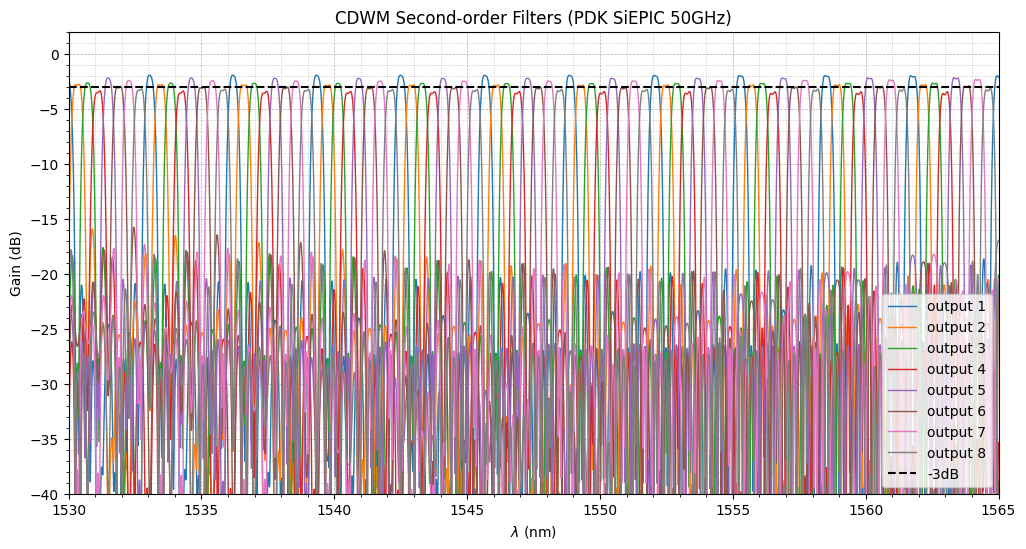

In [21]:
plot_gain(gain_1, gain_2, gain_3, gain_4, gain_5, gain_6, gain_7, gain_8, 'Second', 50)

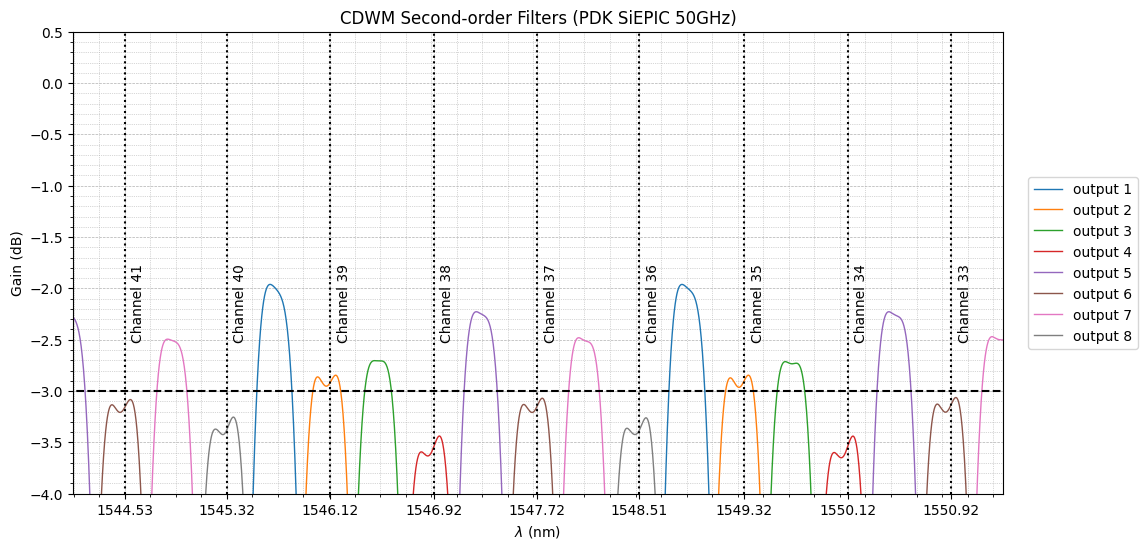

In [22]:
plot_gain_zoom(gain_1, gain_2, gain_3, gain_4, gain_5, gain_6, gain_7, gain_8, 'Second', 50)

# Simulação espaçamento entre canais 100GHz
Pré-requisitos:

- **Número de entradas**: 1  
- **Número de saídas**: 8  
- **Espaçamento entre canais**: 50, 100 e 200 GHz  
- **Banda de operação**: banda C (1530 – 1565 nm)  
- **O filtro deve estar alinhado com os canais definidos pelo padrão ITU da banda C**  
  [https://www.fiberdyne.com/products/pdf/Fiberdyne-ITU-Grid-C-Band-100GHz.pdf](https://www.fiberdyne.com/products/pdf/Fiberdyne-ITU-Grid-C-Band-100GHz.pdf)  
- **Uso de filtros de, no mínimo, segunda ordem**  
- **Uso de acopladores de grade**  
- **Tamanho máximo do circuito**: 500 × 400 µm  
- **Uso da PDK SiePIC**  
  [https://github.com/SiEPIC](https://github.com/SiEPIC)


In [23]:
# Filter parameters
FSR = 2*0.8*nm # 100GHz
center_wvlg = 1549.7 * nm
delta_L = center_wvlg**2 / (ng*FSR)
L = 50*um

delta_L_fs = center_wvlg/neff

L_50 = 17.5 * um
L_29 = 12.5 * um
L_8 = 5 * um

In [24]:
# # First Stage
st3 = filter_2st(L_50, L_29, L_8, L, delta_L, 0,  'st3', -2000, -500)

In [25]:
# Second Stage
st2_A = filter_2st(L_50, L_29, L_8, L, 0.5*delta_L, 0,  'st2_A', -1000, -900)
st2_B = filter_2st(L_50, L_29, L_8, L, 0.5*delta_L, 0.75*delta_L_fs,  'st2_B', -1000, -100)

In [26]:
# Third Stage
st1_A = filter_2st(L_50, L_29, L_8, L, 0.25*delta_L, 0, 'st1_A', 0, -1200)
st1_B = filter_2st(L_50, L_29, L_8, L, 0.25*delta_L, 0.25*delta_L_fs, 'st1_B', 0, -800)
st1_C = filter_2st(L_50, L_29, L_8, L, 0.25*delta_L, 0.125*delta_L_fs, 'st1_C', 0, -400)
st1_D = filter_2st(L_50, L_29, L_8, L, 0.25*delta_L, 0.375*delta_L_fs, 'st1_D', 0, 0)

In [27]:
# Connections
interApi.connect("ONA", "output", st3['coupler_1'] , "opt_2")


interApi.connect(st3['coupler_3'], "opt_3", st2_A['coupler_1'], "opt_2")
interApi.connect(st3['coupler_3'], "opt_4", st2_B['coupler_1'], "opt_1")

interApi.connect(st2_A['coupler_3'], "opt_3", st1_A['coupler_1'], "opt_2")
interApi.connect(st2_A['coupler_3'], "opt_4", st1_B['coupler_1'], "opt_1")
interApi.connect(st2_B['coupler_3'], "opt_3", st1_C['coupler_1'], "opt_2")
interApi.connect(st2_B['coupler_3'], "opt_4", st1_D['coupler_1'], "opt_1")

interApi.connect(st1_A['coupler_3'], "opt_3", "ONA", "input 1")
interApi.connect(st1_A['coupler_3'], "opt_4", "ONA", "input 5")
interApi.connect(st1_B['coupler_3'], "opt_3", "ONA", "input 7")
interApi.connect(st1_B['coupler_3'], "opt_4", "ONA", "input 3")
interApi.connect(st1_C['coupler_3'], "opt_3", "ONA", "input 2")
interApi.connect(st1_C['coupler_3'], "opt_4", "ONA", "input 6")
interApi.connect(st1_D['coupler_3'], "opt_3", "ONA", "input 8")
interApi.connect(st1_D['coupler_3'], "opt_4", "ONA", "input 4")

1.0

In [28]:
interApi.run()

In [29]:
gain_1 = interApi.getresult("ONA", "input 1/mode 1/gain")
gain_2 = interApi.getresult("ONA", "input 2/mode 1/gain")
gain_3 = interApi.getresult("ONA", "input 3/mode 1/gain")
gain_4 = interApi.getresult("ONA", "input 4/mode 1/gain")
gain_5 = interApi.getresult("ONA", "input 5/mode 1/gain")
gain_6 = interApi.getresult("ONA", "input 6/mode 1/gain")
gain_7 = interApi.getresult("ONA", "input 7/mode 1/gain")
gain_8 = interApi.getresult("ONA", "input 8/mode 1/gain")

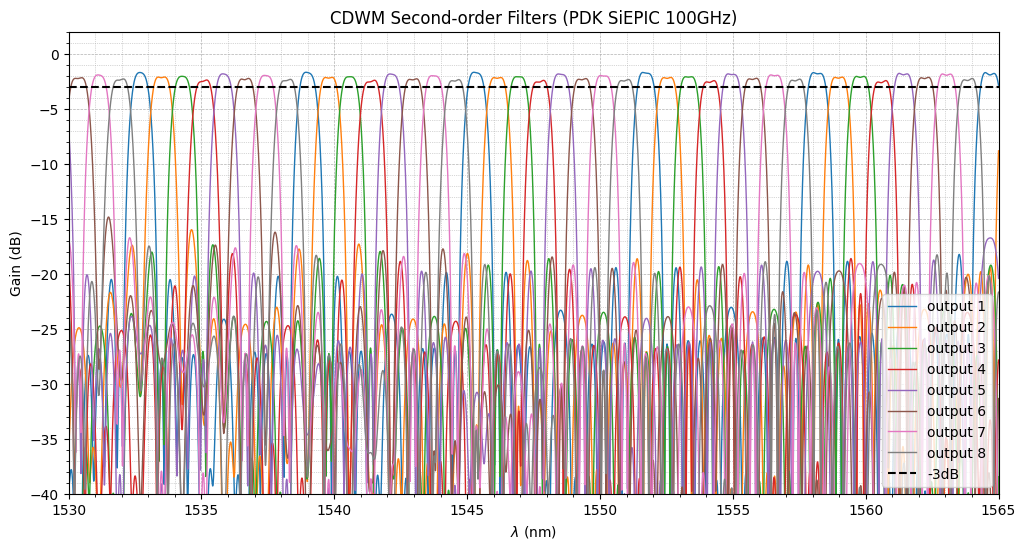

In [30]:
plot_gain(gain_1, gain_2, gain_3, gain_4, gain_5, gain_6, gain_7, gain_8, 'Second', 100)

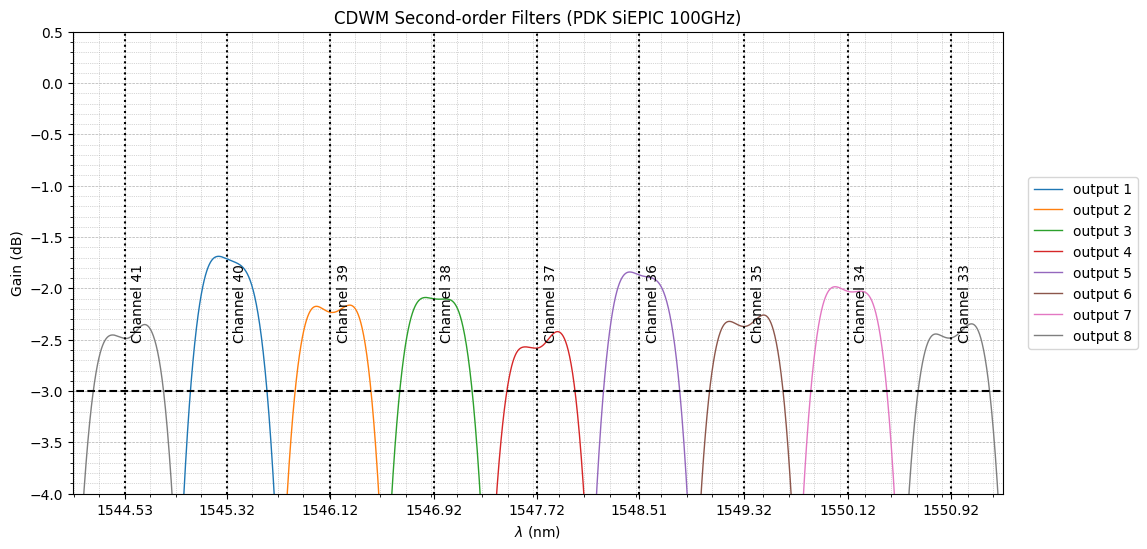

In [31]:
plot_gain_zoom(gain_1, gain_2, gain_3, gain_4, gain_5, gain_6, gain_7, gain_8, 'Second', 100)

# Simulação espaçamento entre canais 200GHz
Pré-requisitos:

- **Número de entradas**: 1  
- **Número de saídas**: 8  
- **Espaçamento entre canais**: 50, 100 e 200 GHz  
- **Banda de operação**: banda C (1530 – 1565 nm)  
- **O filtro deve estar alinhado com os canais definidos pelo padrão ITU da banda C**  
  [https://www.fiberdyne.com/products/pdf/Fiberdyne-ITU-Grid-C-Band-100GHz.pdf](https://www.fiberdyne.com/products/pdf/Fiberdyne-ITU-Grid-C-Band-100GHz.pdf)  
- **Uso de filtros de, no mínimo, segunda ordem**  
- **Uso de acopladores de grade**  
- **Tamanho máximo do circuito**: 500 × 400 µm  
- **Uso da PDK SiePIC**  
  [https://github.com/SiEPIC](https://github.com/SiEPIC)


In [10]:
# Filter parameters
FSR = 2*1.6*nm # 200GHz
center_wvlg = 1549.7 * nm
delta_L = center_wvlg**2 / (ng*FSR)
L = 50*um

delta_L_fs = center_wvlg/neff

L_50 = 17.5 * um
L_29 = 12.5 * um
L_8 = 5 * um

In [11]:
# # First Stage
st3 = filter_2st(L_50, L_29, L_8, L, delta_L, 0,  'st3', -2000, -500)

In [12]:
# Second Stage
st2_A = filter_2st(L_50, L_29, L_8, L, 0.5*delta_L, 0,  'st2_A', -1000, -900)
st2_B = filter_2st(L_50, L_29, L_8, L, 0.5*delta_L, 0.75*delta_L_fs,  'st2_B', -1000, -100)

In [14]:
# Third Stage
st1_A = filter_2st(L_50, L_29, L_8, L, 0.25*delta_L, 0, 'st1_A', 0, -1200)
st1_B = filter_2st(L_50, L_29, L_8, L, 0.25*delta_L, 0.25*delta_L_fs, 'st1_B', 0, -800)
st1_C = filter_2st(L_50, L_29, L_8, L, 0.25*delta_L, 0.125*delta_L_fs, 'st1_C', 0, -400)
st1_D = filter_2st(L_50, L_29, L_8, L, 0.25*delta_L, 0.375*delta_L_fs, 'st1_D', 0, 0)

In [ ]:
# Connections
interApi.connect("ONA", "output", st3['coupler_1'] , "opt_2")


interApi.connect(st3['coupler_3'], "opt_3", st2_A['coupler_1'], "opt_2")
interApi.connect(st3['coupler_3'], "opt_4", st2_B['coupler_1'], "opt_1")

interApi.connect(st2_A['coupler_3'], "opt_3", st1_A['coupler_1'], "opt_2")
interApi.connect(st2_A['coupler_3'], "opt_4", st1_B['coupler_1'], "opt_1")
interApi.connect(st2_B['coupler_3'], "opt_3", st1_C['coupler_1'], "opt_2")
interApi.connect(st2_B['coupler_3'], "opt_4", st1_D['coupler_1'], "opt_1")

interApi.connect(st1_A['coupler_3'], "opt_3", "ONA", "input 1")
interApi.connect(st1_A['coupler_3'], "opt_4", "ONA", "input 5")
interApi.connect(st1_B['coupler_3'], "opt_3", "ONA", "input 7")
interApi.connect(st1_B['coupler_3'], "opt_4", "ONA", "input 3")
interApi.connect(st1_C['coupler_3'], "opt_3", "ONA", "input 2")
interApi.connect(st1_C['coupler_3'], "opt_4", "ONA", "input 6")
interApi.connect(st1_D['coupler_3'], "opt_3", "ONA", "input 8")
interApi.connect(st1_D['coupler_3'], "opt_4", "ONA", "input 4")

1.0

In [37]:
interApi.run()

In [38]:
gain_1 = interApi.getresult("ONA", "input 1/mode 1/gain")
gain_2 = interApi.getresult("ONA", "input 2/mode 1/gain")
gain_3 = interApi.getresult("ONA", "input 3/mode 1/gain")
gain_4 = interApi.getresult("ONA", "input 4/mode 1/gain")
gain_5 = interApi.getresult("ONA", "input 5/mode 1/gain")
gain_6 = interApi.getresult("ONA", "input 6/mode 1/gain")
gain_7 = interApi.getresult("ONA", "input 7/mode 1/gain")
gain_8 = interApi.getresult("ONA", "input 8/mode 1/gain")

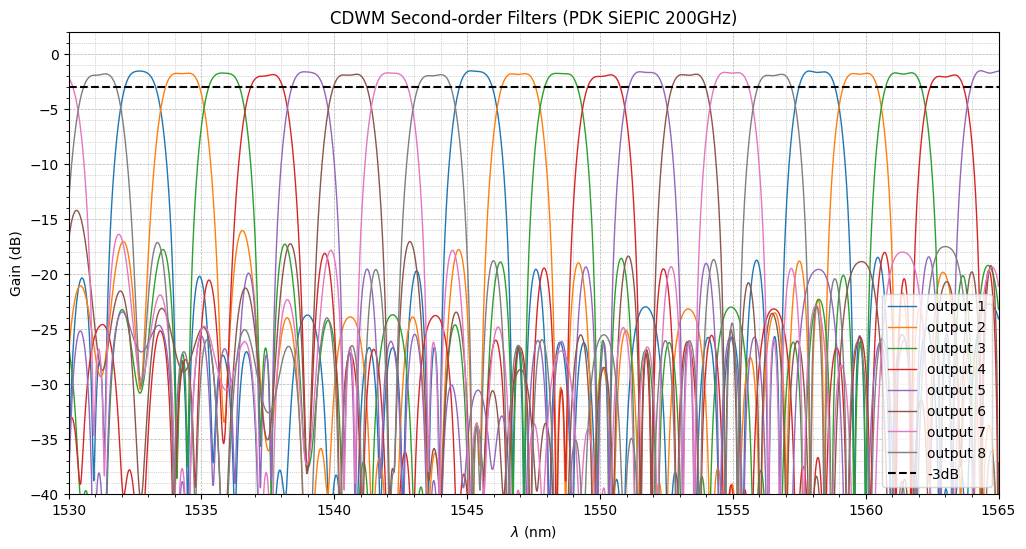

In [39]:
plot_gain(gain_1, gain_2, gain_3, gain_4, gain_5, gain_6, gain_7, gain_8, 'Second', 200)

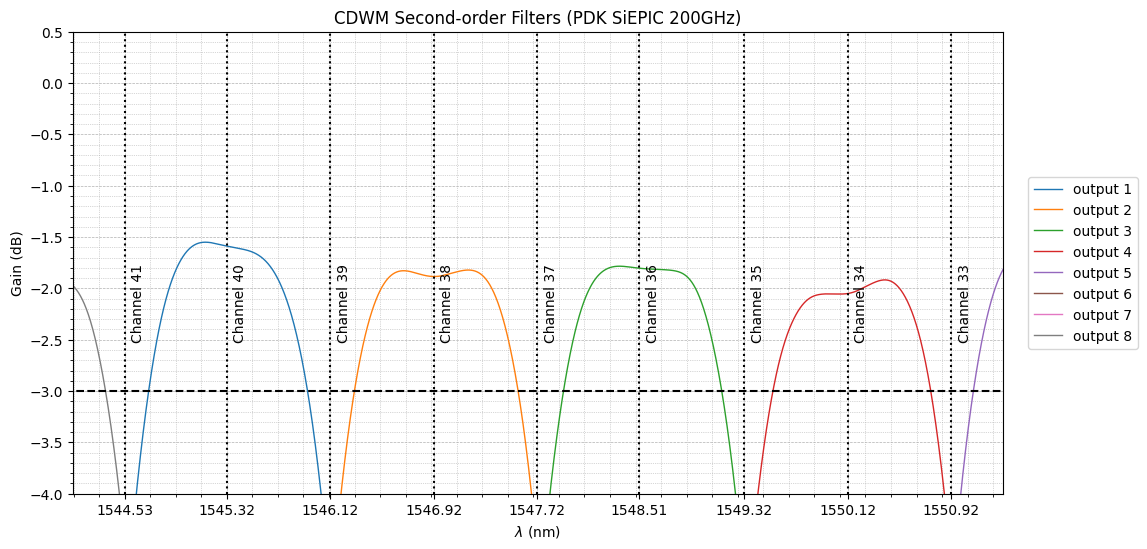

In [40]:
plot_gain_zoom(gain_1, gain_2, gain_3, gain_4, gain_5, gain_6, gain_7, gain_8, 'Second', 200)